# Импорты

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy

In [19]:
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I

In [20]:
def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

# Задание 1

In [21]:
def get_controllability_gramian(A, B, end_time):
    f = lambda time: scipy.linalg.expm(A * time) @ B @ B.T @ scipy.linalg.expm(A.T * time)
    return scipy.integrate.quad_vec(f, 0, end_time)

In [22]:
def get_u_for_controllable(A, B, x1, end_time):
    u = []
    times = get_t(end_time)
    control_gramian_matrix, _ = get_controllability_gramian(A, B, end_time)
    for t in times:
        u.append(B.T @ scipy.linalg.expm(A.T * (end_time - t)) @ np.linalg.pinv(control_gramian_matrix) @ x1)
    return np.array(u).reshape((B.shape[1], -1)), times

In [23]:
def plot_task1(A, B, x1, end_time):
    u, times = get_u_for_controllable(A, B, x1, end_time)
    ss = control.ss(A, B, A * 0, B * 0)
    output = control.forced_response(ss, X0=[0,0,0], U=u, T=times).states

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(3):
        axs[0].plot(times, output[i], linewidth=4, label=f"$x_{i}$")
        # axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
        axs[0].set_xlabel(f"t, [c]", fontsize=12)
        axs[0].grid(True)
        
    axs[0].set_title(f"Графики компонент")
    axs[0].scatter([end_time, end_time, end_time], [x1[0], x1[1], x1[2]], color='r', linewidth=4, label='Цель')
    axs[0].legend()
    
    axs[1].set_title(f"График сигнала управления ")
    axs[1].plot(times, u.reshape(-1), linewidth=4, label="Управление")
    axs[1].set_xlabel(f"t, [c]", fontsize=12)
    axs[1].grid(True)
    axs[1].legend()
    plt.show()

In [24]:
task1_A = np.array([
    [3, 4, -1],
    [-10, -11, -4],
    [10, 10, 3]
])
task1_B = np.array([[-2], [5], [-3]])
task1_x1 = np.array([[-2], [1], [-1]])
task1_end_time = 3

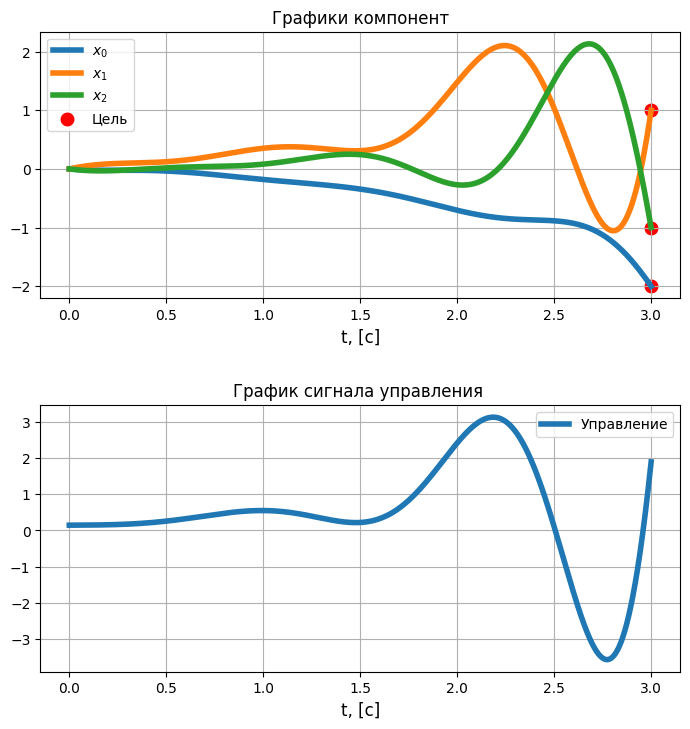

In [25]:
plot_task1(task1_A, task1_B, task1_x1, task1_end_time)

# Задание 2

In [26]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m


In [27]:
def check_controllability(A, B, end_time):
    print('======== System check ==========')
    A_sympy, B_sympy = sympy.Matrix(A), sympy.Matrix(B)
    U = get_controllability_matrix(A, B)
    print(f'U: \n{U}')
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {val}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")
    A_P, A_J = A_sympy.jordan_form()
    print(f'Jordan of A: {A_J}')
    print(f'B^ = {(A_P ** -1 ) * B_sympy}')
    control_gramian_matrix, control_gramian_error = get_controllability_gramian(A, B, end_time)
    print(f'Controllability Gramian at {end_time}s: \n{control_gramian_matrix}')
    print(f'Eigen values of Controllability Gramian at {end_time}s: {np.linalg.eigvals(control_gramian_matrix)}')

In [28]:
def check_controllability_of_point(A, B, x1):
    print(f'======== Controllability of {x1.reshape(-1)} ==========')
    U = get_controllability_matrix(A, B)
    rgU = np.linalg.matrix_rank(U)
    print(f'Rang(U): \n {rgU}')
    
    U_extended = np.hstack((U, x1))
    rgU_extended = np.linalg.matrix_rank(np.hstack((U, x1)))
    print(f'U_ext: \n {U_extended}')
    print(f'Rang(U_ext) = {rgU_extended}')
    
    controllable =  rgU_extended == rgU
    print(f'In Controllable Space: {controllable}')
    return controllable

In [29]:
task2_A = np.array([
    [3, 4, -1],
    [-10, -11, -4],
    [10, 10, 3]
])

task2_B = np.array([[2], [1], [-1]])

task2_mbx1 = np.array([[-2], [1], [-1]])
task2_mbx2 = np.array([[-5], [4], [-1]])

task2_end_time = 3

In [30]:
check_controllability(task2_A, task2_B, task2_end_time)
is_mbx1 = check_controllability_of_point(task2_A, task2_B, task2_mbx1)
is_mbx2 = check_controllability_of_point(task2_A, task2_B, task2_mbx2)


======== System check ==========
U: 
[[   2   11 -102]
 [   1  -27   79]
 [  -1   27  -79]]
RankU = 2
Eigen values of A:
   (-1.999999999999999+5j): controllable
   (-1.999999999999999-5j): controllable
   (-1+0j): not controllable
Jordan of A: Matrix([[-1, 0, 0], [0, -2 - 5*I, 0], [0, 0, -2 + 5*I]])
B^ = Matrix([[0], [-1/2 + 5*I/2], [-1/2 - 5*I/2]])
Controllability Gramian at 3s: 
[[ 2.05602665 -1.63361588  1.63361588]
 [-1.63361588  2.40515848 -2.40515848]
 [ 1.63361588 -2.40515848  2.40515848]]
Eigen values of Controllability Gramian at 3s: [ 6.12276851e+00  7.43575100e-01 -7.66500595e-32]
======== Controllability of [-2  1 -1] ==========
Rang(U): 
 2
U_ext: 
 [[   2   11 -102   -2]
 [   1  -27   79    1]
 [  -1   27  -79   -1]]
Rang(U_ext) = 2
In Controllable Space: True
======== Controllability of [-5  4 -1] ==========
Rang(U): 
 2
U_ext: 
 [[   2   11 -102   -5]
 [   1  -27   79    4]
 [  -1   27  -79   -1]]
Rang(U_ext) = 3
In Controllable Space: False


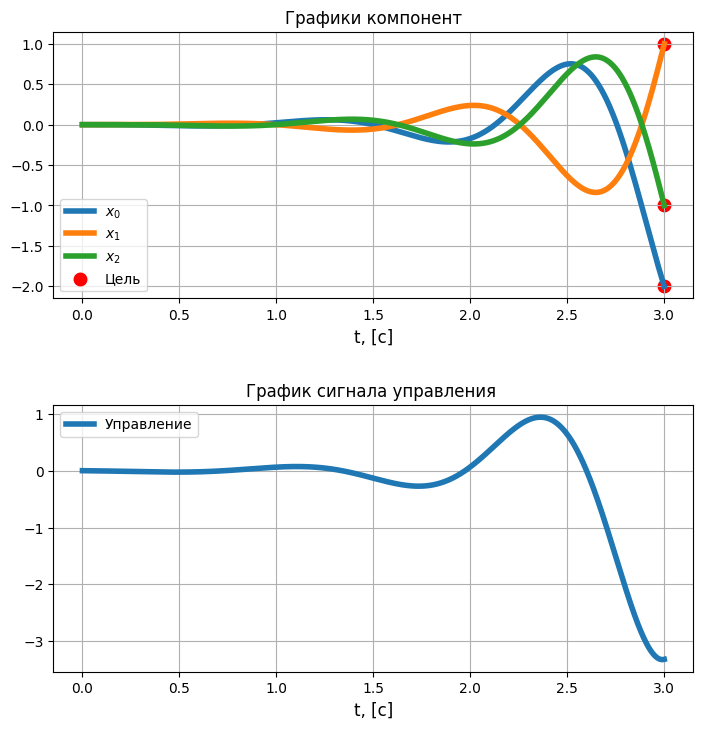

In [31]:
plot_task1(task2_A, task2_B, task2_mbx1, task1_end_time, 'task1')

# Задание 3

In [32]:
task3_A = np.array([
    [-21, -38, 6],
    [8, 13, -4],
    [-6, -14, -1]
])

task3_C = np.array([9, 18, -2]).reshape((1, 3))

task3_y = lambda x: 3 * np.exp(-5 * x) * np.cos(2 * x) - np.exp(-5 * x) * np.sin(2 * x)

task3_end_time = 3

In [33]:
def get_observability_matrix(A, C):
    ctrb_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_gramian(A, C, end_time):
    f = lambda time: scipy.linalg.expm(A.T * time) @ C.T @ C @ scipy.linalg.expm(A * time)
    return scipy.integrate.quad_vec(f, 0, end_time)

def check_observability(A, C, end_time):
    print('======== System check ==========')
    A_sympy, C_sympy = sympy.Matrix(A), sympy.Matrix(C)
    V = get_observability_matrix(A, C)
    print(f'V: \n{V}')
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {val}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")
    A_P, A_J = A_sympy.jordan_form()
    print(f'Jordan of A: {A_J}')
    print(f'C^ = {C_sympy * A_P}')
    observability_gramian_matrix, observability_gramian_error = get_observability_gramian(A, C, end_time)
    print(f'Observability Gramian at {end_time}s: \n{observability_gramian_matrix}')
    print(f'Eigen values of Observability Gramian at {end_time}s: {np.linalg.eigvals(observability_gramian_matrix)}')
    

def check_non_observability_of_point(A, C, x1):
    print(f'======== Non observability of {x1.reshape(-1)} ==========')
    V = get_observability_matrix(A, C)
    non_observable = np.allclose(V @ x1, 0)
    print(f'In Non observable Space: {non_observable}')
    return non_observable

def get_initial_state_for_observable(A, C, y_lambda, end_time):
    observability_gramian_matrix, _ = get_observability_gramian(A, C, end_time)
    f = lambda time: scipy.linalg.expm(A.T * time) @ C.T @ np.array(y_lambda(time)).reshape(C.shape[0], -1)
    inv_gramian = np.linalg.pinv(observability_gramian_matrix)
    return inv_gramian @ scipy.integrate.quad_vec(f, 0, end_time)[0]


In [44]:
def plot_task3(A, C, y_lambda, end_time):
    times = get_t(3)
    x0 = get_initial_state_for_observable(A, C, y_lambda, end_time)
    print(x0)
    ss = control.ss(A, A * 0, C, C * 0)
    res = control.forced_response(ss, X0=x0, U=0, T=times)
    output = res.states

    fig, axs = plt.subplots(2, figsize=(16, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(3):
        axs[0].plot(times, output[i], linewidth=4)
        axs[0].set_title(f'x(t)', fontsize=12)
        axs[0].set_xlabel(f"t, [c]", fontsize=12)
        axs[0].grid(True)
        axs[0].legend()
        
    axs[0].scatter([0, 0, 0], x0, color='r', linewidth=4, label='initial')    
        
    axs[1].plot(times, res.outputs.reshape(-1), linewidth=4)
    axs[1].scatter(0, C @ x0, color='r', linewidth=4, label='initial')
    axs[1].set_title(f'График сигнала выхода y(t)', fontsize=12)
    axs[1].set_xlabel(f"t, [c]", fontsize=12)
    axs[1].grid(True)
    return x0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


======== System check ==========
V: 
[[  9  18  -2]
 [-33 -80 -16]
 [149 438 138]]
RankV = 3
Eigen values of A:
   (1.0000000000000262+0j): observable
   (-5.000000000000009+1.999999999999993j): observable
   (-5.000000000000009-1.999999999999993j): observable
Jordan of A: Matrix([[1, 0, 0], [0, -5 - 2*I, 0], [0, 0, -5 + 2*I]])
C^ = Matrix([[-2, 7, 7]])
Observability Gramian at 3s: 
[[  815.01961811  1627.79441208  -809.9023922 ]
 [ 1627.79441208  3251.43710693 -1618.06685681]
 [ -809.9023922  -1618.06685681   807.99551112]]
Eigen values of Observability Gramian at 3s: [4.87201653e+03 5.70726112e-02 2.37863082e+00]
[[ 1.        ]
 [-0.28571429]
 [ 0.42857143]]


array([], shape=(3, 0), dtype=float64)

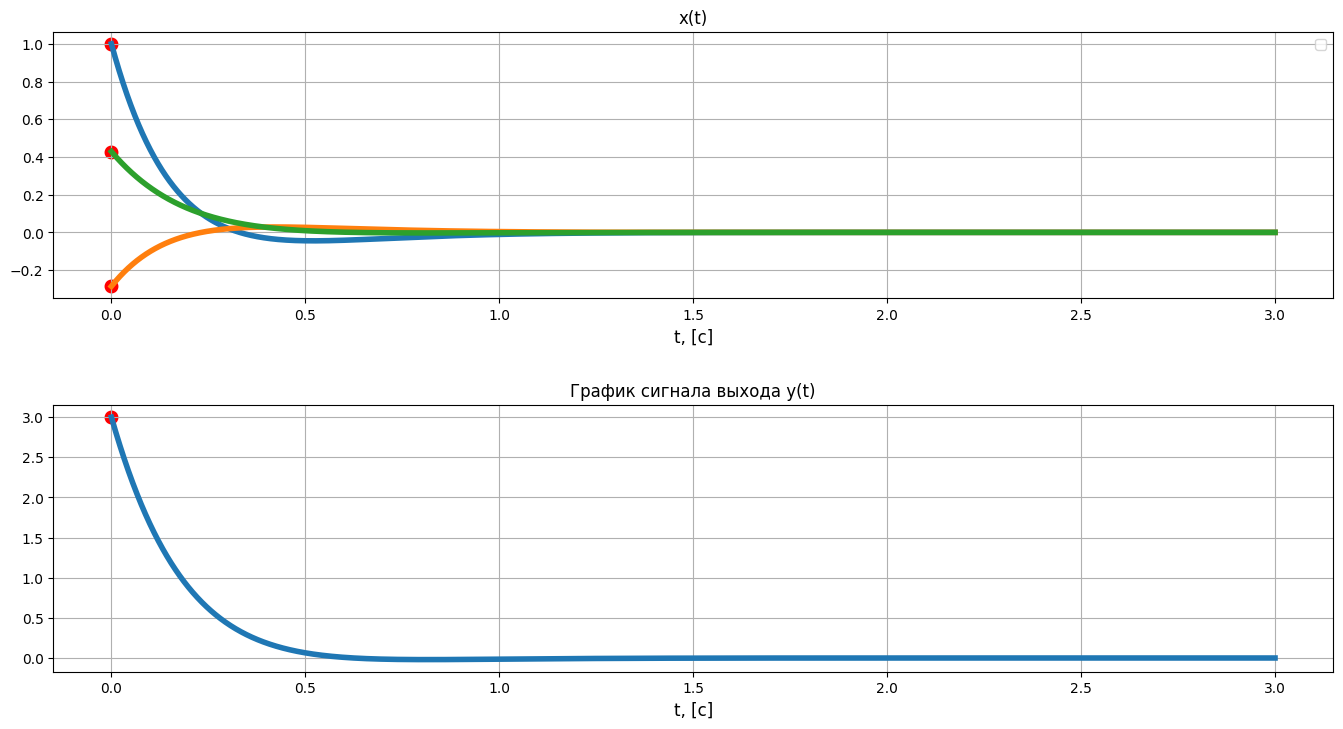

In [45]:
check_observability(task3_A, task3_C, task3_end_time)
plot_task3(task3_A, task3_C, task3_y, task3_end_time)
V = get_observability_matrix(task3_A, task3_C)
null_space_vec = scipy.linalg.null_space(V)
null_space_vec

# Задание 4

In [50]:
task4_A = np.array([
    [-21, -38, 6],
    [8, 13, -4],
    [-6, -14, -1]
])

task4_C = np.array([7, 14, 0]).reshape((1, 3))

task4_y = lambda x: 3 * np.exp(-5 * x) * np.cos(2 * x) - np.exp(-5 * x) * np.sin(2 * x)

task4_end_time = 3

In [51]:
check_observability(task4_A, task4_C, task4_end_time)

======== System check ==========
V: 
[[  7  14   0]
 [-35 -84 -14]
 [147 434 140]]
RankV = 2
Eigen values of A:
   (1.0000000000000262+0j): not observable
   (-5.000000000000009+1.999999999999993j): observable
   (-5.000000000000009-1.999999999999993j): observable
Jordan of A: Matrix([[1, 0, 0], [0, -5 - 2*I, 0], [0, 0, -5 + 2*I]])
C^ = Matrix([[0, 7, 7]])
Observability Gramian at 3s: 
[[ 4.56206897  8.27931034 -0.84482759]
 [ 8.27931034 15.20689655 -1.35172414]
 [-0.84482759 -1.35172414  0.33793103]]
Eigen values of Observability Gramian at 3s: [1.98567251e+01 5.24995752e-16 2.50171475e-01]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


======== System check ==========
V: 
[[  7  14   0]
 [-35 -84 -14]
 [147 434 140]]
RankV = 2
Eigen values of A:
   (1.0000000000000262+0j): not observable
   (-5.000000000000009+1.999999999999993j): observable
   (-5.000000000000009-1.999999999999993j): observable
Jordan of A: Matrix([[1, 0, 0], [0, -5 - 2*I, 0], [0, 0, -5 + 2*I]])
C^ = Matrix([[0, 7, 7]])
Observability Gramian at 3s: 
[[ 4.56206897  8.27931034 -0.84482759]
 [ 8.27931034 15.20689655 -1.35172414]
 [-0.84482759 -1.35172414  0.33793103]]
Eigen values of Observability Gramian at 3s: [1.98567251e+01 5.24995752e-16 2.50171475e-01]
[[ 0.0952381 ]
 [ 0.16666667]
 [-0.02380952]]


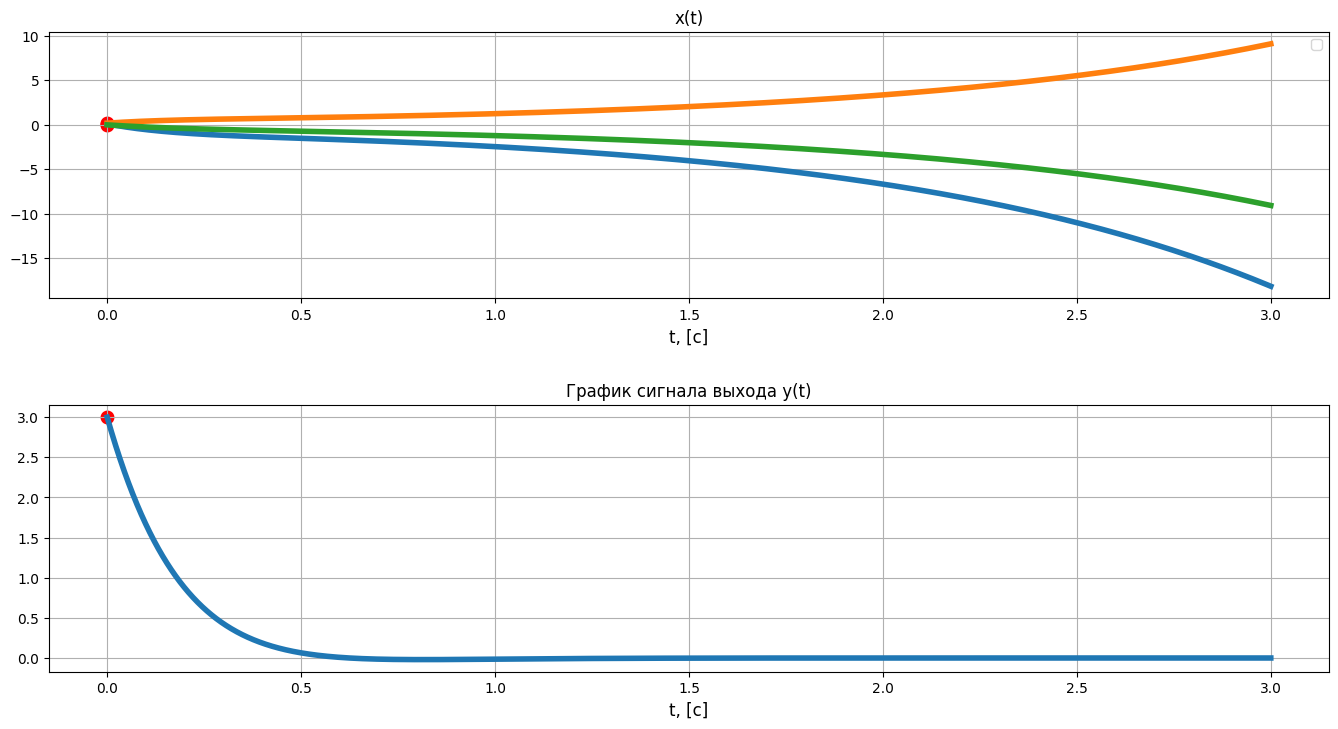

In [53]:
check_observability(task4_A, task4_C, task4_end_time)
plot_task3(task4_A, task4_C, task4_y, task4_end_time)
V = get_observability_matrix(task4_A, task4_C)

In [54]:
null_space_vec = scipy.linalg.null_space(V)
null_space_vec

array([[-0.81649658],
       [ 0.40824829],
       [-0.40824829]])

In [63]:
def plot_task4(A, C, x0, y_lambda, end_time):
    times = get_t(3)
    # x0 = get_initial_state_for_observable(A, C, y_lambda, end_time)
    print(x0)
    ss = control.ss(A, A * 0, C, C * 0)
    res = control.forced_response(ss, X0=x0, U=0, T=times)
    output = res.states

    fig, axs = plt.subplots(2, figsize=(16, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(3):
        axs[0].plot(times, output[i], linewidth=4)
        axs[0].set_title(f'x(t)', fontsize=12)
        axs[0].set_xlabel(f"t, [c]", fontsize=12)
        axs[0].grid(True)
        axs[0].legend()
        
    axs[0].scatter([0, 0, 0], x0, color='r', linewidth=4, label='initial')    
        
    axs[1].plot(times, res.outputs.reshape(-1), linewidth=4)
    axs[1].scatter(0, C @ x0, color='r', linewidth=4, label='initial')
    axs[1].set_title(f'График сигнала выхода y(t)', fontsize=12)
    axs[1].set_xlabel(f"t, [c]", fontsize=12)
    axs[1].grid(True)
    return x0
    

In [72]:
x0_1 = [-0.81, 0.41, -0.41]
x0_2 = [-0.81*2, 0.41*2, -0.41*2]
x0_3 = [-0.81*5, 0.41*5, -0.41*5]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.81, 0.41, -0.41]


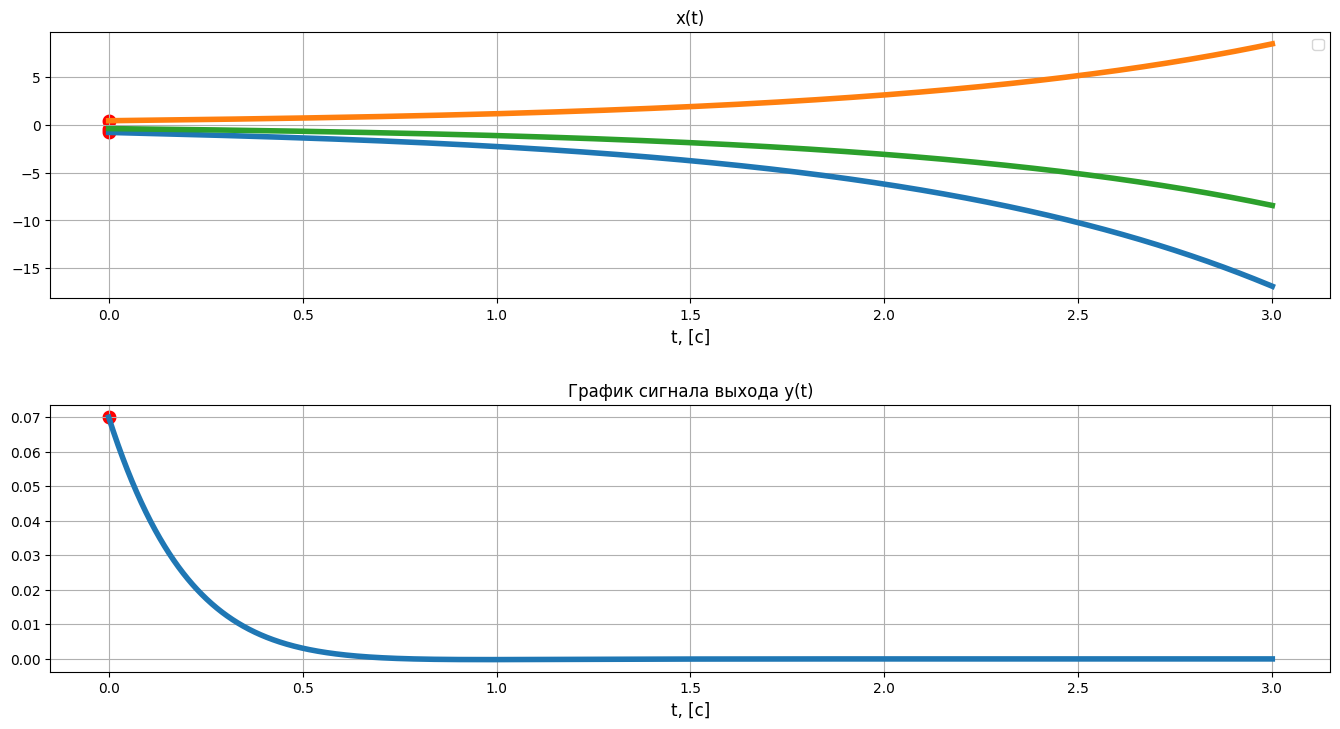

In [73]:
plot_task4(task4_A, task4_C, x0_1, task4_y, task4_end_time)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-1.62, 0.82, -0.82]


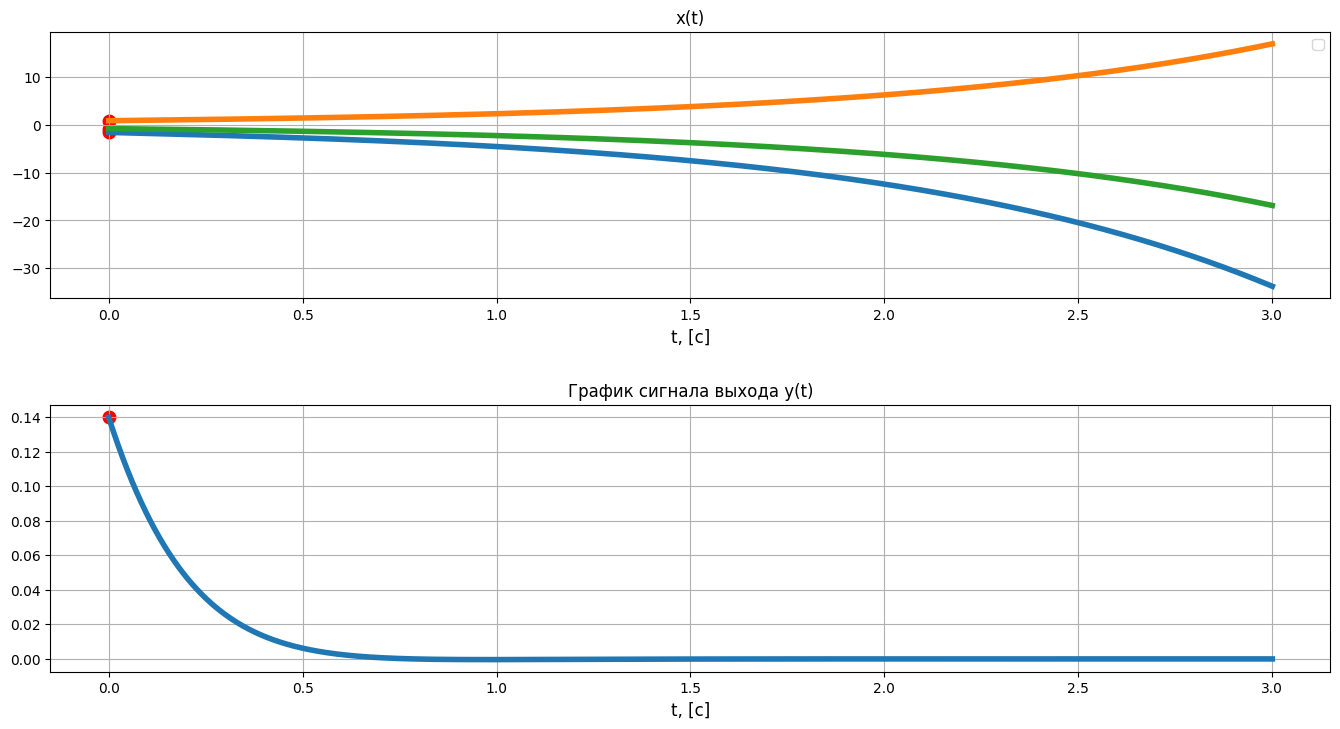

In [74]:
plot_task4(task4_A, task4_C, x0_2, task4_y, task4_end_time)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-4.050000000000001, 2.05, -2.05]


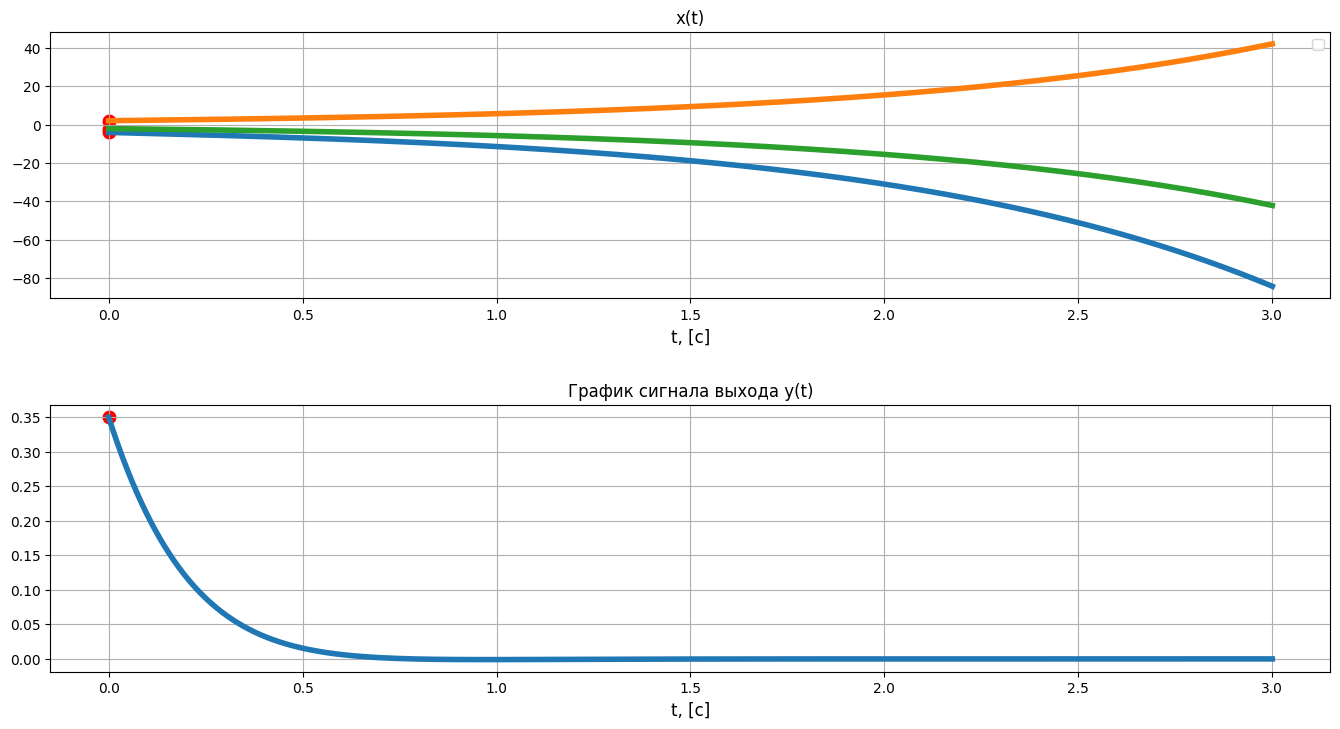

In [75]:
plot_task4(task4_A, task4_C, x0_3, task4_y, task4_end_time)